In [1]:
import torch
import torch.nn as nn
from modules import SAB, PMA
import numpy as np


def gen_data(batch_size, max_length=10, test=False):
    length = np.random.randint(1, max_length + 1)
    x = np.random.randint(1, 100, (batch_size, length))
    y = np.max(x, axis=1)
    x, y = np.expand_dims(x, axis=2), np.expand_dims(y, axis=1)
    return x, y


class SmallDeepSet(nn.Module):
    def __init__(self, pool="max"):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(in_features=1, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
        )
        self.dec = nn.Sequential(
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1),
        )
        self.pool = pool

    def forward(self, x):
        x = self.enc(x)
        if self.pool == "max":
            x = x.max(dim=1)[0]
        elif self.pool == "mean":
            x = x.mean(dim=1)
        elif self.pool == "sum":
            x = x.sum(dim=1)
        x = self.dec(x)
        return x


class SmallSetTransformer(nn.Module):
    def __init__(self,):
        super().__init__()
        self.enc = nn.Sequential(
            SAB(dim_in=1, dim_out=64, num_heads=4),
            SAB(dim_in=64, dim_out=64, num_heads=4),
        )
        self.dec = nn.Sequential(
            PMA(dim=64, num_heads=4, num_seeds=1),
            nn.Linear(in_features=64, out_features=1),
        )

    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x.squeeze(-1)


def train(model):
    model = model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.L1Loss().cuda()
    losses = []
    for _ in range(500):
        x, y = gen_data(batch_size=2 ** 10, max_length=10)
        x, y = torch.from_numpy(x).float().cuda(), torch.from_numpy(y).float().cuda()
        loss = criterion(model(x), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [2]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.set(rc={"figure.figsize": (8, 4)}, style="whitegrid")

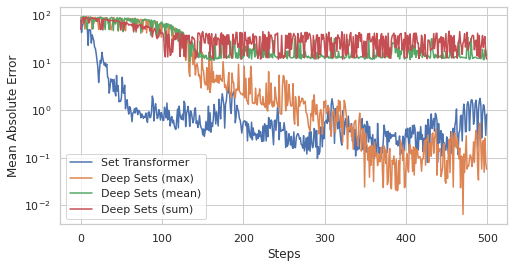

In [3]:
models = [
    ("Set Transformer", SmallSetTransformer()),
    ("Deep Sets (max)", SmallDeepSet("max")),
    ("Deep Sets (mean)", SmallDeepSet("mean")),
    ("Deep Sets (sum)", SmallDeepSet("sum")),
]

for _name, _model in models:
    _losses = train(_model)
    plt.plot(_losses, label=_name)
plt.legend()
plt.xlabel("Steps")
plt.ylabel("Mean Absolute Error")
plt.yscale("log")
plt.show()